# Treinamento de Rede Neural com Tensorflow para análise do sinal

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from files_01_detection.const_mod import generate_symbols, Model
from files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2022-12-19 11:26:38.561686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 11:26:38.561710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 11:26:38.592529: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 11:26:39.308019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-19 11:26:39.308095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

## Definição e transmissão do sinal pelo canal

In [2]:
Mod = 'PSK'
channel_type = 'rayleigh' # 'awgn' or 'crazy'
M            = 8      # PSK modulation
total_num_symbols  = 1000000    # Number of transmitted symbols to be used for training and test
train_fraction = 0.5 # Fraction of whole data to be used for training (the remaining is for testing)
SNR_dB       = 15      # Signal to noise ratio in dB     
code_rate    = 1       # Rate of the used code
Es           = 1       # Average symbol energy

In [3]:
#plot theoretical symbol error probability (SER) for this SNR
Pe = theoretical_error(Mod, M, SNR_dB, channel_type, epb=False)
print("Theoretical symbol error probability (SER) =", Pe*100, "% for SNR =", SNR_dB,"dB")

Theoretical symbol error probability (SER) = 3.4155801424019416 % for SNR = 15 dB


In [4]:
def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):
    symbs, indices, channel_output = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB)
    y = np.append(np.array([[]]), indices[:])
    x = np.stack([np.real(channel_output[:]),
                    np.imag(channel_output[:])], axis=1)
    
    if scaler is not None:
        x = scaler(x)
        
    if symb:
        return x, y, symbs
    else:
        return x, y

In [5]:
x_out, y_out, symbs = conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, True)

In [6]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

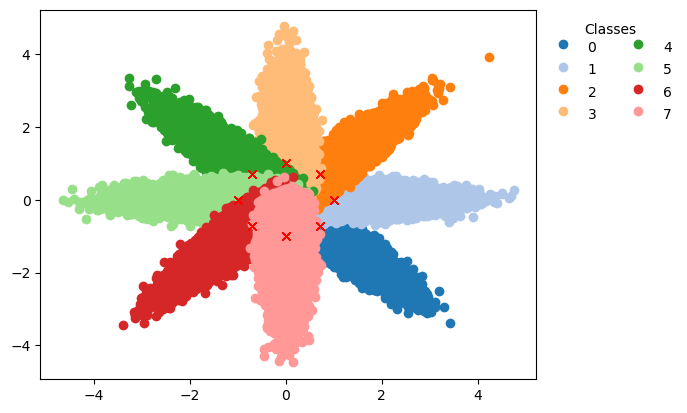

In [7]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [8]:
n_inputs = np.shape(X_train)[1]
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.01
n_epochs = 30
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

2022-12-19 11:26:43.837934: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 11:26:43.838099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-19 11:26:43.838225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-19 11:26:43.838368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-19 11:26:43.838497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Usando API Keras

In [9]:
inputs = tf.keras.Input(shape=(2,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)


output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

modelK = tf.keras.Model(inputs=inputs, outputs=output)

modelK.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 150)               450       
                                                                 
 dense_1 (Dense)             (None, 80)                12080     
                                                                 
 dense_2 (Dense)             (None, 50)                4050      
                                                                 
 dense_3 (Dense)             (None, 8)                 408       
                                                                 
Total params: 16,988
Trainable params: 16,988
Non-trainable params: 0
_________________________________________________________________


In [10]:
modelK.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
             metrics=["accuracy"])

history = modelK.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = modelK.evaluate(X_test, y_test)
print("Test loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}")

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.3518 - accuracy: 0.8920
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2585 - accuracy: 0.9078
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2530 - accuracy: 0.9079
Epoch 4/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2487 - accuracy: 0.9081
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2454 - accuracy: 0.9079
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2428 - accuracy: 0.9079
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2412 - accuracy: 0.9079
Epoch 8/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2400 - accuracy: 0.9079
Epoch 9/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2393 - accuracy: 0.9077
Epoch 10/30
625/625 [==============================] - 2s 4ms/step - loss: 0.2388 - accuracy: 0.9079

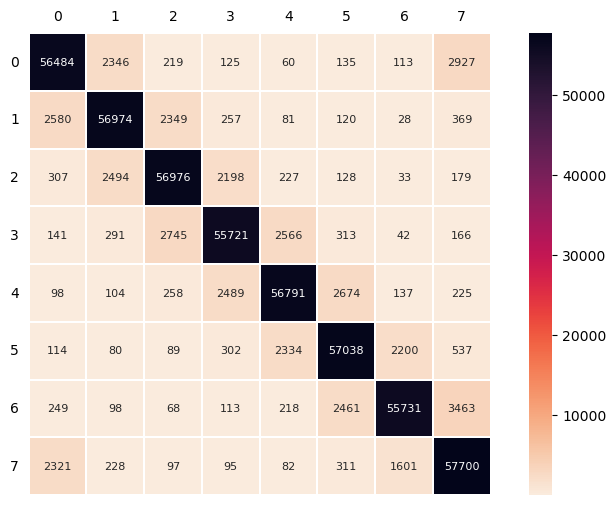

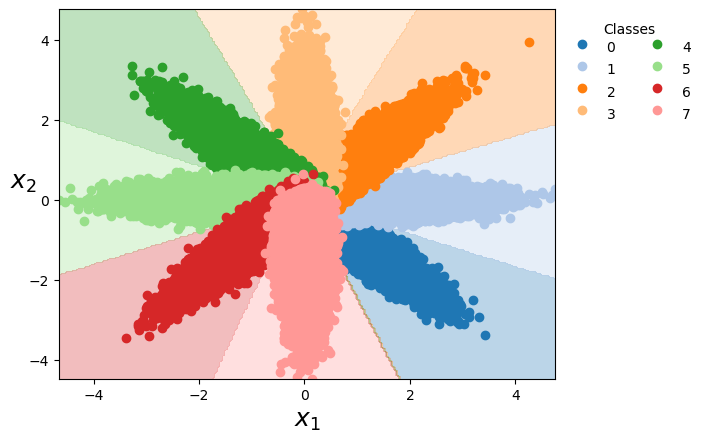

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


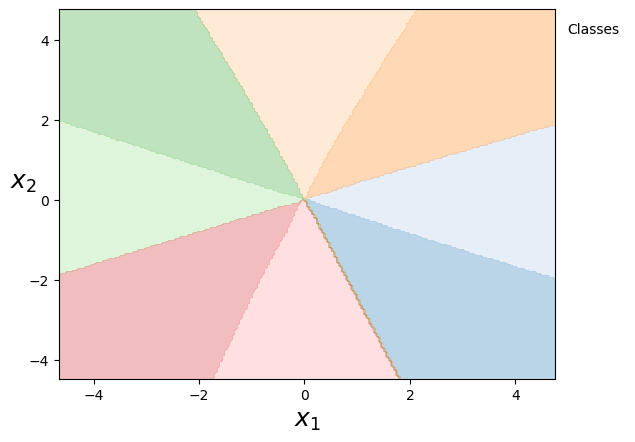

In [11]:
plot_confusion_matrix(modelK, X_test, y_test, M, nn=True)
plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### PSK | Rayleigh

In [12]:
Mod = "PSK"
channel_type = "rayleigh"
M = 8

In [13]:
Teo_SNRs = [theoretical_error(Mod, M, 12 + i, channel_type) for i in range(7)]

In [14]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[i] * np.log2(M))), M, channel_type, Es, code_rate, 12 + i, False, scaler.transform) for i in range(7)]

In [17]:
error_rate = ([ser(modelK, tf.convert_to_tensor(amostras[i][0]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(7)]) / (tf.math.log(float(M))/tf.math.log(2.))

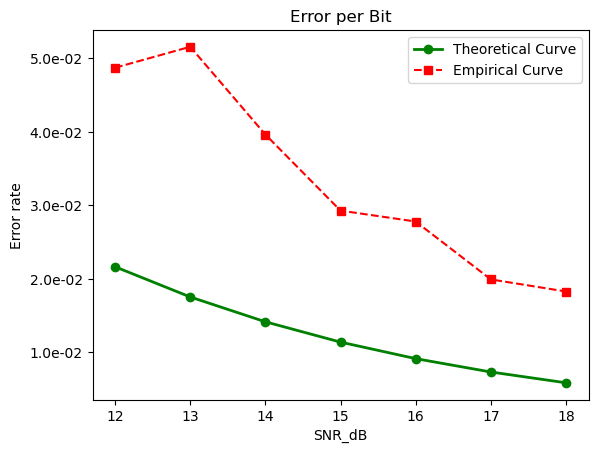

In [18]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(12,19)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('Error per Bit')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### PSK | AWGN

In [19]:
Mod = 'PSK'
channel_type = 'awgn'
M = 8

In [20]:
Teo_SNRs = [theoretical_error(Mod, M, 12 + i, channel_type) for i in range(7)]

In [21]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[i] * np.log2(M))), M, channel_type, Es, code_rate, 12 + i, False, scaler.transform) for i in range(7)]

In [29]:
error_rate = ([ser(modelK, tf.convert_to_tensor(amostras[i][0]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(7)]) / (tf.math.log(float(M))/tf.math.log(2.))

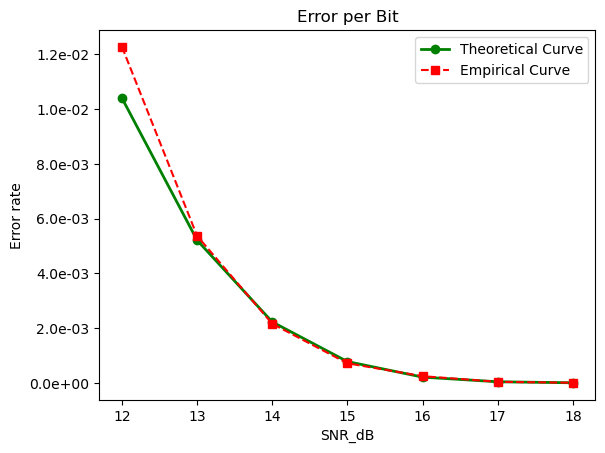

In [30]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(12,19)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('Error per Bit')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

## Modelo QAM

In [31]:
Mod = "QAM"
channel_type = "rayleigh"
M = 16

In [32]:
x_out, y_out, symbs = conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, True)

In [33]:
# Generate dataset
# Train
train_size = int(train_fraction*total_num_symbols) #data used for training
y_train = y_out[:train_size]
X_train = x_out[:train_size]

# Test
y_test = y_out[train_size:]
X_test = x_out[train_size:]

scaler = StandardScaler()
scaler.fit(X_train)  # Don't cheat - fit only on training data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

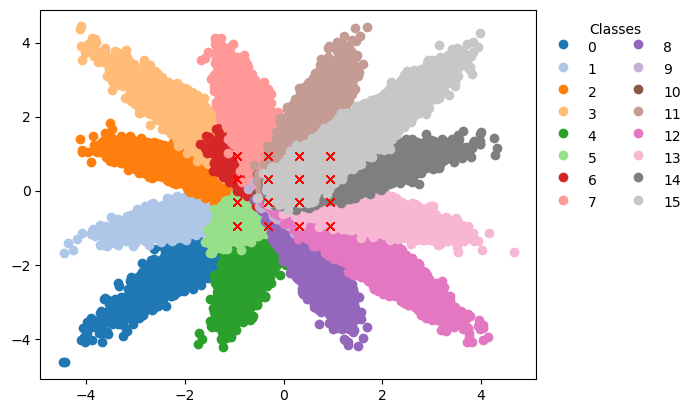

In [34]:
plot_symbols(X_train, y_train, M, symbs)

## Criação e treinamento da Rede Neural

In [35]:
n_inputs = np.shape(X_train)[1]
#n_hidden1 = 300
n_hidden1 = 150
n_hidden2 = 80
n_hidden3 = 50

n_outputs = M
learning_rate = 0.001
n_epochs = 30
batch_size = 800

y_train = tf.reshape(tf.convert_to_tensor(y_train), [-1, 1])
y_test = tf.reshape(tf.convert_to_tensor(y_test), [-1, 1])
X_test = tf.convert_to_tensor(X_test)
X_train = tf.convert_to_tensor(X_train)

### Usando API Keras

In [36]:
inputs = tf.keras.Input(shape=(2,))

x = tf.keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="glorot_normal")(inputs)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

x = tf.keras.layers.Dense(n_hidden3, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

#x = tf.keras.layers.Dense(n_hidden4, activation="elu", kernel_initializer="glorot_normal")(x)
#x = tf.keras.layers.BatchNormalization(momentum=0.99)(x)
#x = tf.keras.layers.Activation("elu")(x)

output = tf.keras.layers.Dense(n_outputs, kernel_initializer="glorot_normal")(x)
#output = tf.keras.layers.BatchNormalization(momentum=0.99)(output)

modelQ = tf.keras.Model(inputs=inputs, outputs=output)

modelQ.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 150)               450       
                                                                 
 dense_5 (Dense)             (None, 80)                12080     
                                                                 
 dense_6 (Dense)             (None, 50)                4050      
                                                                 
 dense_7 (Dense)             (None, 16)                816       
                                                                 
Total params: 17,396
Trainable params: 17,396
Non-trainable params: 0
_________________________________________________________________


In [37]:
modelQ.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(),#experimental.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
             metrics=["accuracy"])

history = modelQ.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, shuffle=True)

tests_score = modelQ.evaluate(X_test, y_test)
print("Test loss:", tests_score[0])
print("Test accuracy:", tests_score[1])
print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}")

Epoch 1/30
625/625 [==============================] - 3s 4ms/step - loss: 0.8534 - accuracy: 0.7003
Epoch 2/30
625/625 [==============================] - 2s 4ms/step - loss: 0.7303 - accuracy: 0.7292
Epoch 3/30
625/625 [==============================] - 2s 4ms/step - loss: 0.7268 - accuracy: 0.7296
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7252 - accuracy: 0.7298
Epoch 5/30
625/625 [==============================] - 2s 4ms/step - loss: 0.7242 - accuracy: 0.7306
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 0.7243 - accuracy: 0.7300
Epoch 7/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7239 - accuracy: 0.7299
Epoch 8/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7239 - accuracy: 0.7303
Epoch 9/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7233 - accuracy: 0.7303
Epoch 10/30
625/625 [==============================] - 3s 4ms/step - loss: 0.7236 - accuracy: 0.7301

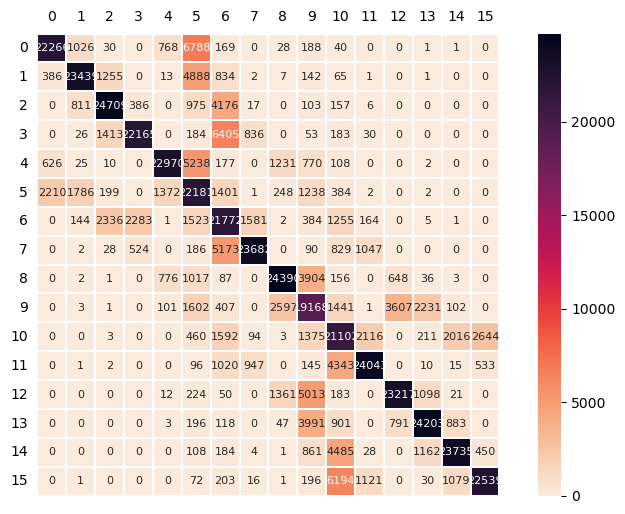

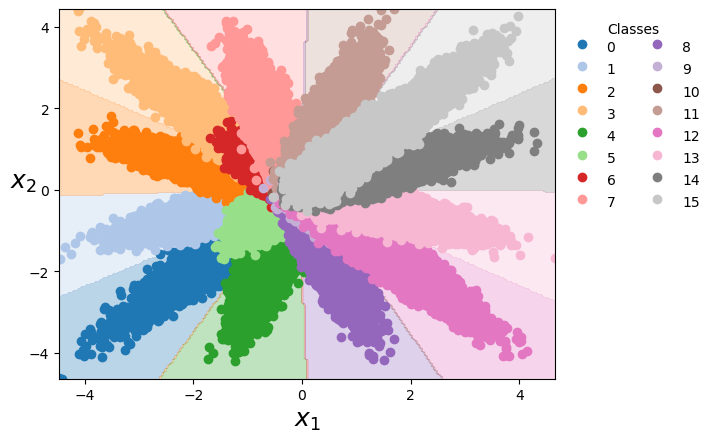

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


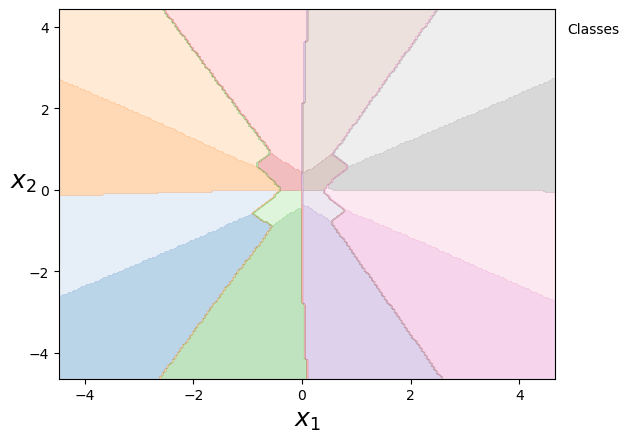

In [38]:
plot_confusion_matrix(modelQ, X_test, y_test, M, nn=True)
plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True)
plot_decision_boundary(modelQ, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

In [42]:
Mod = 'QAM'
channel_type = 'rayleigh'
M = 16

In [43]:
Teo_SNRs = [theoretical_error(Mod, M, 12 + i, channel_type) for i in range(7)]

In [44]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[i] * np.log2(M))), M, channel_type, Es, code_rate, 12 + i, False, scaler.transform) for i in range(7)]

In [45]:
error_rate = ([ser(modelQ, tf.convert_to_tensor(amostras[i][0]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(7)]) / (tf.math.log(float(M))/tf.math.log(2.))

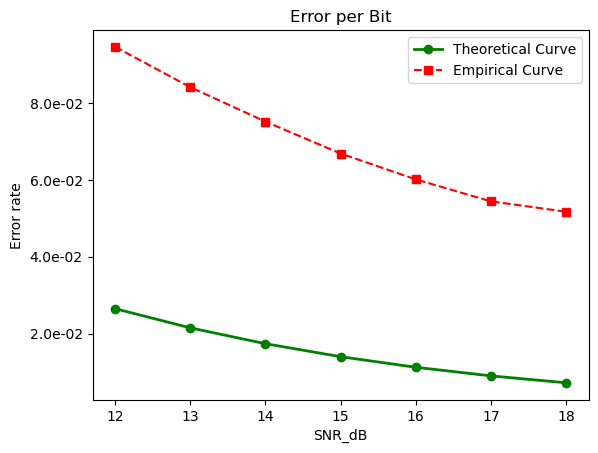

In [46]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(12,19)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('Error per Bit')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.set_yscale("linear")
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()

### QAM | AWGN

In [47]:
Mod = 'QAM'
channel_type = 'awgn'
M = 16

In [48]:
Teo_SNRs = [theoretical_error(Mod, M, 12 + i, channel_type) for i in range(7)]

In [49]:
amostras = [conjunto(Mod, int(100 / (Teo_SNRs[i] * np.log2(M))), M, channel_type, Es, code_rate, 12 + i, False, scaler.transform) for i in range(7)]

In [50]:
error_rate = ([ser(modelQ, tf.convert_to_tensor(amostras[i][0]),
                              tf.reshape(tf.convert_to_tensor(amostras[i][1]), [-1, 1]), nn=True)
              for i in range(7)]) / (tf.math.log(float(M))/tf.math.log(2.))

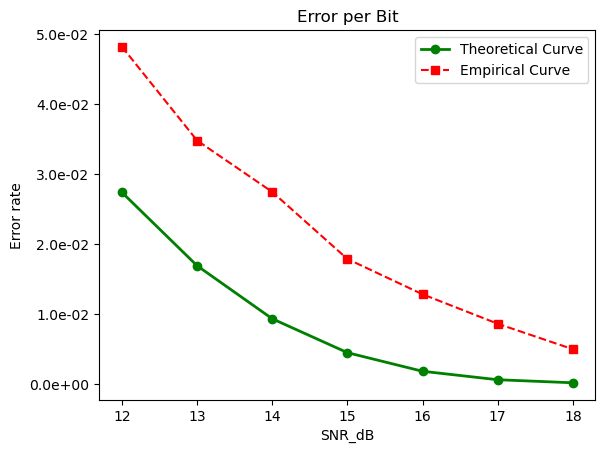

In [51]:
import matplotlib.ticker as tick

y1 = Teo_SNRs
x = range(12,19)
y2 = error_rate

fig, ax = plt.subplots(1,1)

ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
ax.plot(x, y2, 'rs--', label='Empirical Curve')
ax.set_title('Error per Bit')
ax.set_xlabel('SNR_dB')
ax.set_ylabel('Error rate')

def y_fmt(x, y):
    return '{:2.1e}'.format(x)

ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
#plt.plot(x2, y2, 'rs--',  label='line 2')

plt.legend()
plt.show()